In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

In [2]:
class PPO(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PPO, self).__init__()
        self.data = []
        self.gamma = 0.98

        # GAE를 제시한 논문의 파라미터
        self.lmbda = 0.95
        self.eps = 0.1
        self.K = 3

        self.fc1 = nn.Linear(state_dim, 256)
        self.fc_pi = nn.Linear(256, action_dim)
        self.fc_v = nn.Linear(256, 1)
        self.optimizer = optim.Adam(self.parameters(), lr=0.0001)

    # A3C 기반 policy network과 value state Network 둘다 있음
    # 시뮬레이션 할떄는 softmax_dim = 0 이유는 환경이 하나 들어가기 때문
    # 학습 할 때는 배치가 여러개로 들어가서 dim=1 
    def pi(self, x, softmax_dim=0):
        x = F.relu(self.fc1(x))
        x = self.fc_pi(x)
        prob = F.softmax(x, dim=softmax_dim)
        return prob

    def v(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v

    def put_data(self, item):
        self.data.append(item)

    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []
        for item in self.data:
            s, a, r, s_prime, prob_a, done = item

            # s 는 array라 shape 맞춰줄려고 나머지 얘뜰도 대괄호에 넣어 dim 맞춰줌
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            prob_a_lst.append([prob_a])
            done_mask = 0 if done else 1
            done_lst.append([done_mask])

        s, a, r, s_prime, done_mask, prob_a = (
            torch.tensor(s_lst, dtype=torch.float),
            torch.tensor(a_lst),
            torch.tensor(r_lst),
            torch.tensor(s_prime_lst, dtype=torch.float),
            torch.tensor(done_lst, dtype=torch.float),
            torch.tensor(prob_a_lst))
        self.data = []
        return s, a, r, s_prime, done_mask, prob_a

    def train(self):
        s, a, r, s_prime, done_mask, prob_a = self.make_batch()

        # 함수 호출을 여러번 할수록 오래 걸리기 때문에 s_prime 배치를 함수에 한번에 넘겨줌
        for i in range(self.K):
            td_target = r + self.gamma * self.v(s_prime) * done_mask
            delta = td_target - self.v(s)
            # numpy는 adavantage 계산에 필요
            delta = delta.detach().numpy()

            advantage_lst = []
            advantage = 0
            for delta_t in delta[::-1]:
                advantage = self.gamma * self.lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float)

            pi = self.pi(s, softmax_dim=1)
            pi_a = pi.gather(1, a)
            ratio = torch.exp(torch.log(pi_a) - torch.log(prob_a))
            # prob_a 과거의 확률 pi_a 최신의 확률

            surr1 = ratio * advantage
            surr2 = torch.clip(ratio, 1 - self.eps, 1 + self.eps) * advantage
            # clipping을 넘어가면 업데이트를 아예 안함
            loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(td_target.detach(), self.v(s))
            # td_target을 detach하는 이유는 target이기 때문 state value function이 
            # td_target에 가까워지게 학습해야 함.

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()


def main():
    env = gym.make('CartPole-v1')
    model = PPO(state_dim=4, action_dim=2)
    T = 20
    score = 0.0
    print_interval = 20
    # T는 몇 타임스탭 동안 data를 모을지
    score_lst = []

    for n_epi in range(2000):
        s, _ = env.reset()

        step_count = 0

        done = False
        while not done:
            for t in range(T):
                prob = model.pi(torch.from_numpy(s).float())
                m = Categorical(prob)
                a = m.sample().item()
                s_prime, r, terminated, truncated, info = env.step(a)
                done = truncated or terminated

                decreasing_reward = r * (0.99 ** step_count)
                step_count += 1

                # info는 뭐지
                # prob[a].item() -> 실제 한 action의 확률값 나중에 ratio 계산에 쓰임
                # 나중에 PPO에서 old policy 의 확률값 사용함.
                # r은 그냥 맘대로 100 분의 일 사용 이래도 되나?
                model.put_data((s, a, decreasing_reward, s_prime, prob[a].item(), done))
                s = s_prime

                score += r
                if done:
                    break

            model.train()

        if n_epi % print_interval == 0 and n_epi != 0:
            print(f"# of episode :{n_epi}, avg score : {score / print_interval:.1f}")
            score_lst.append(score / print_interval)
            score = 0.0

    env.close()

    return score_lst

# if __name__ == '__main__':
#     score_lst = main()

In [47]:
import os
import numpy as np
from PPO_model import SimpleEnv
import pandas as pd
from utils.PCA_and_ETC import read_and_preprocess_data, momentum_prefix_finder

input_dir = 'Database/Clustering_Result/Best'
subdirectories = [d for d in os.listdir(input_dir)]
MOM_merged_df = pd.read_csv('Database/Momentum1_Winsorized.csv', index_col=0)
MOM_merged_df.drop(MOM_merged_df.columns[0], axis=1, inplace=True)

T = 50
score = 0.0
print_interval = 20
# T는 몇 타임스탭 동안 data를 모을지
score_lst = []
a_lst = []
action_values = [0.5, 1.0, 1.5]

model_dict = {}
for subdir in subdirectories:
    model_dict[subdir] = PPO(state_dim=4, action_dim=3)
    base_directory = f'{input_dir}/{subdir}'
    files = sorted(filename for filename in os.listdir(base_directory) if filename.endswith('.csv'))
    i = 0
    # 환경 생성
    env = SimpleEnv()

    for file, next_file in zip(files, files[1:]):
        if pd.to_datetime(file[:-4]) > pd.to_datetime('1999-12'):
            break
        i += 1
        step_count = 0
        print(file)
        data = read_and_preprocess_data(base_directory, file)

        if i <= 12:
            env.reset(data, next_file)
            continue

        s = env.reset(data, next_file, True)

        for t in range(T):
            prob = model_dict[subdir].pi(torch.from_numpy(s).float())
            m = Categorical(prob)
            action_idx = m.sample().item()
            a = action_values[action_idx]
            a_lst.append(a)
            score_lst.append(score)

            s_prime, r, done, _ = env.step(a, data, next_file)

            # print(f"State: {s_prime}, Action: {a}, Reward: {r}")

            decreasing_reward = r * (0.99 ** step_count)
            step_count += 1

            model_dict[subdir].put_data((s, action_idx, decreasing_reward, s_prime, prob[action_idx].item(), done))
            s = s_prime

            score += r

        model_dict[subdir].train()

        if i % print_interval == 0 and i != 0:
            print(f"# of episode :{i}, avg score : {score / print_interval:.1f}")
            # score_lst.append(score / print_interval)
            score = 0.0

    env.close()

1990-01.csv
1990-02.csv
1990-03.csv
1990-04.csv
1990-05.csv
1990-06.csv
1990-07.csv
1990-08.csv
1990-09.csv
1990-10.csv
1990-11.csv
1990-12.csv
1991-01.csv
1991-02.csv
1991-03.csv
1991-04.csv
1991-05.csv
1991-06.csv
1991-07.csv
1991-08.csv
# of episode :20, avg score : 14.9
1991-09.csv
1991-10.csv
1991-11.csv
1991-12.csv
1992-01.csv
1992-02.csv
1992-03.csv
1992-04.csv
1992-05.csv
1992-06.csv
1992-07.csv
1992-08.csv
1992-09.csv
1992-10.csv
1992-11.csv
1992-12.csv
1993-01.csv
1993-02.csv
1993-03.csv
1993-04.csv
# of episode :40, avg score : 16.0
1993-05.csv
1993-06.csv
1993-07.csv
1993-08.csv
1993-09.csv
1993-10.csv
1993-11.csv
1993-12.csv
1994-01.csv
1994-02.csv
1994-03.csv
1994-04.csv
1994-05.csv
1994-06.csv
1994-07.csv
1994-08.csv
1994-09.csv
1994-10.csv
1994-11.csv
1994-12.csv
# of episode :60, avg score : 11.7
1995-01.csv
1995-02.csv
1995-03.csv
1995-04.csv
1995-05.csv
1995-06.csv
1995-07.csv
1995-08.csv
1995-09.csv
1995-10.csv
1995-11.csv
1995-12.csv
1996-01.csv
1996-02.csv
1996-03

In [48]:
MOM_merged_df = pd.read_csv('Database/Momentum1_Winsorized.csv', index_col=0)
MOM_merged_df.drop(MOM_merged_df.columns[0], axis=1, inplace=True)


def backtesting(data, next_file, reinforcement, model):
    prefix = momentum_prefix_finder(data)

    mom1_col_name = prefix + '1'

    cluster = []
    for j in range(1 + max(set(data['clusters']))):
        indices = list(data[data['clusters'] == j].index)
        cluster.append(indices)

    clusters = []
    for i in range(len(cluster)):
        for firms in cluster[i]:
            clusters.append([firms, i])

    clusters = pd.DataFrame(clusters, columns=['Firm Name', 'Cluster Index'])
    clusters = clusters.set_index('Firm Name')
    clusters['Momentum_1'] = data[mom1_col_name]
    # clusters = clusters.sort_values(by=['Cluster Index', 'Momentum_1'], ascending=[True, False])
    clusters = clusters.sort_values(by=['Cluster Index', 'Momentum_1', 'Firm Name'], ascending=[True, False, True])

    spread_vec = (clusters.reset_index()['Momentum_1'] -
                  clusters.sort_values(by=['Cluster Index', 'Momentum_1', 'Firm Name'],
                                       ascending=[True, True, True]).reset_index()['Momentum_1'])

    return_df = MOM_merged_df.loc[:, next_file[:-4]]
    clusters = clusters.reset_index()
    clusters['spread'] = spread_vec
    prob = 0
    if reinforcement:
        state = np.array(
            [np.mean(return_df.fillna(0)), np.std(return_df.fillna(0)), clusters['spread'].mean(),
             clusters['spread'].std()])
        # clusters['spread'][clusters['Cluster Index'] != 0].std()
        prob = model.pi(torch.from_numpy(state).float())
        m = Categorical(prob)
        action_idx = m.sample().item()
        action = action_values[action_idx]

    if not reinforcement:
        action = 1
    clusters['in_portfolio'] = (clusters['spread'].abs() > clusters['spread'].std() * action)
    clusters['Long Short'] = clusters['in_portfolio'] * (-clusters['spread'] / clusters['spread'].abs())
    clusters['Long Short'] = clusters['Long Short'].fillna(0)

    # clusters = clusters.drop(columns=['spread', 'in_portfolio'])
    clusters.loc[clusters['Cluster Index'] == 0, 'Long Short'] = 0
    clusters['Long'] = clusters['Long Short'].apply(lambda x: 1 if x == 1 else 0)
    clusters['Short'] = clusters['Long Short'].apply(lambda x: -1 if x == -1 else 0)

    clusters.set_index('Firm Name', inplace=True)

    MOM_merged_df.sort_values('Firm Name', inplace=True)

    prod = MOM_merged_df.loc[clusters[clusters['Long Short'] != 0].index, next_file[:-4]]
    prod = prod * clusters['Long Short']
    prod = prod.apply(lambda x: -0.30 if x < -0.30 else x)

    mask = ((clusters['Long Short'] == 1) | (clusters['Long Short'] == -1)) & prod.isna()
    prod[mask] = -0.5

    prod = prod.apply(lambda x: np.log(x + 1))

    non_zero_count = clusters['Long Short'].astype(bool).sum()
    column_sums = prod.sum()
    reward = column_sums / non_zero_count

    return reward, action, prob


return_dict2 = {}
action_dict2 = {}
prob_dict = {}
for subdir in subdirectories:
    return_lst = []
    action_lst = []
    prob_lst = []
    base_directory = f'{input_dir}/{subdir}'
    files = sorted(filename for filename in os.listdir(base_directory) if filename.endswith('.csv'))

    for file, next_file in zip(files, files[1:]):
        if pd.to_datetime(file[:-4]) <= pd.to_datetime('1999-12'):
            continue
        print(file)
        data = read_and_preprocess_data(base_directory, file)
        reward, action, prob = backtesting(data, next_file, True, model_dict[subdir])
        return_lst.append(reward)
        action_lst.append(action)
        prob_lst.append(prob)

    return_dict2[subdir] = return_lst
    action_dict2[subdir] = action_lst
    prob_dict[subdir] = prob_lst

2000-01.csv
2000-02.csv
2000-03.csv
2000-04.csv
2000-05.csv
2000-06.csv
2000-07.csv
2000-08.csv
2000-09.csv
2000-10.csv
2000-11.csv
2000-12.csv
2001-01.csv
2001-02.csv
2001-03.csv
2001-04.csv
2001-05.csv
2001-06.csv
2001-07.csv
2001-08.csv
2001-09.csv
2001-10.csv
2001-11.csv
2001-12.csv
2002-01.csv
2002-02.csv
2002-03.csv
2002-04.csv
2002-05.csv
2002-06.csv
2002-07.csv
2002-08.csv
2002-09.csv
2002-10.csv
2002-11.csv
2002-12.csv
2003-01.csv
2003-02.csv
2003-03.csv
2003-04.csv
2003-05.csv
2003-06.csv
2003-07.csv
2003-08.csv
2003-09.csv
2003-10.csv
2003-11.csv
2003-12.csv
2004-01.csv
2004-02.csv
2004-03.csv
2004-04.csv
2004-05.csv
2004-06.csv
2004-07.csv
2004-08.csv
2004-09.csv
2004-10.csv
2004-11.csv
2004-12.csv
2005-01.csv
2005-02.csv
2005-03.csv
2005-04.csv
2005-05.csv
2005-06.csv
2005-07.csv
2005-08.csv
2005-09.csv
2005-10.csv
2005-11.csv
2005-12.csv
2006-01.csv
2006-02.csv
2006-03.csv
2006-04.csv
2006-05.csv
2006-06.csv
2006-07.csv
2006-08.csv
2006-09.csv
2006-10.csv
2006-11.csv
2006

In [49]:
for subdir in subdirectories:
    print(subdir)
    print(np.mean([np.array(prob[0].detach()) for prob in prob_dict[subdir]]))
    print(np.mean([np.array(prob[1].detach()) for prob in prob_dict[subdir]]))
    print(np.mean([np.array(prob[2].detach()) for prob in prob_dict[subdir]]))

Agglomerative
0.32439002
0.3717947
0.30381528
Contrastive_Learning
0.32224908
0.38979116
0.28795975
DBSCAN
0.34666646
0.31341273
0.33992082
K-mean
0.44665107
0.34004474
0.21330419


In [50]:
for subdir in subdirectories:
    print(subdir)
    print((np.exp(np.mean(pd.DataFrame(return_dict[subdir]).fillna(0)) * 12) - 1) / (
                np.exp(np.std(pd.DataFrame(return_dict[subdir]).fillna(0)) * np.sqrt(12)) - 1))

Agglomerative
0    1.181424
dtype: float64
Contrastive_Learning
0    1.270419
dtype: float64
DBSCAN
0    0.698648
dtype: float64
K-mean
0    1.207437
dtype: float64


In [51]:
for subdir in subdirectories:
    print(subdir)
    print((np.exp(np.mean(pd.DataFrame(return_dict2[subdir]).fillna(0)) * 12) - 1) / (
                np.exp(np.std(pd.DataFrame(return_dict2[subdir]).fillna(0)) * np.sqrt(12)) - 1))

Agglomerative
0    1.23122
dtype: float64
Contrastive_Learning
0    1.230963
dtype: float64
DBSCAN
0    1.082381
dtype: float64
K-mean
0    1.121258
dtype: float64


In [52]:
for subdir in subdirectories:
    print(subdir)
    print((np.exp(np.mean(pd.DataFrame(return_dict[subdir]).fillna(0)) * 12) - 1))

Agglomerative
0.1156092866467171
Contrastive_Learning
0.23696874072057006
DBSCAN
0.08836044616201466
K-mean
0.11173486548071421


In [53]:
for subdir in subdirectories:
    print(subdir)
    print((np.exp(np.mean(pd.DataFrame(return_dict2[subdir]).fillna(0)) * 12) - 1))

Agglomerative
0.13569365305157
Contrastive_Learning
0.2401450114969328
DBSCAN
0.11099934587399729
K-mean
0.10978649823592534


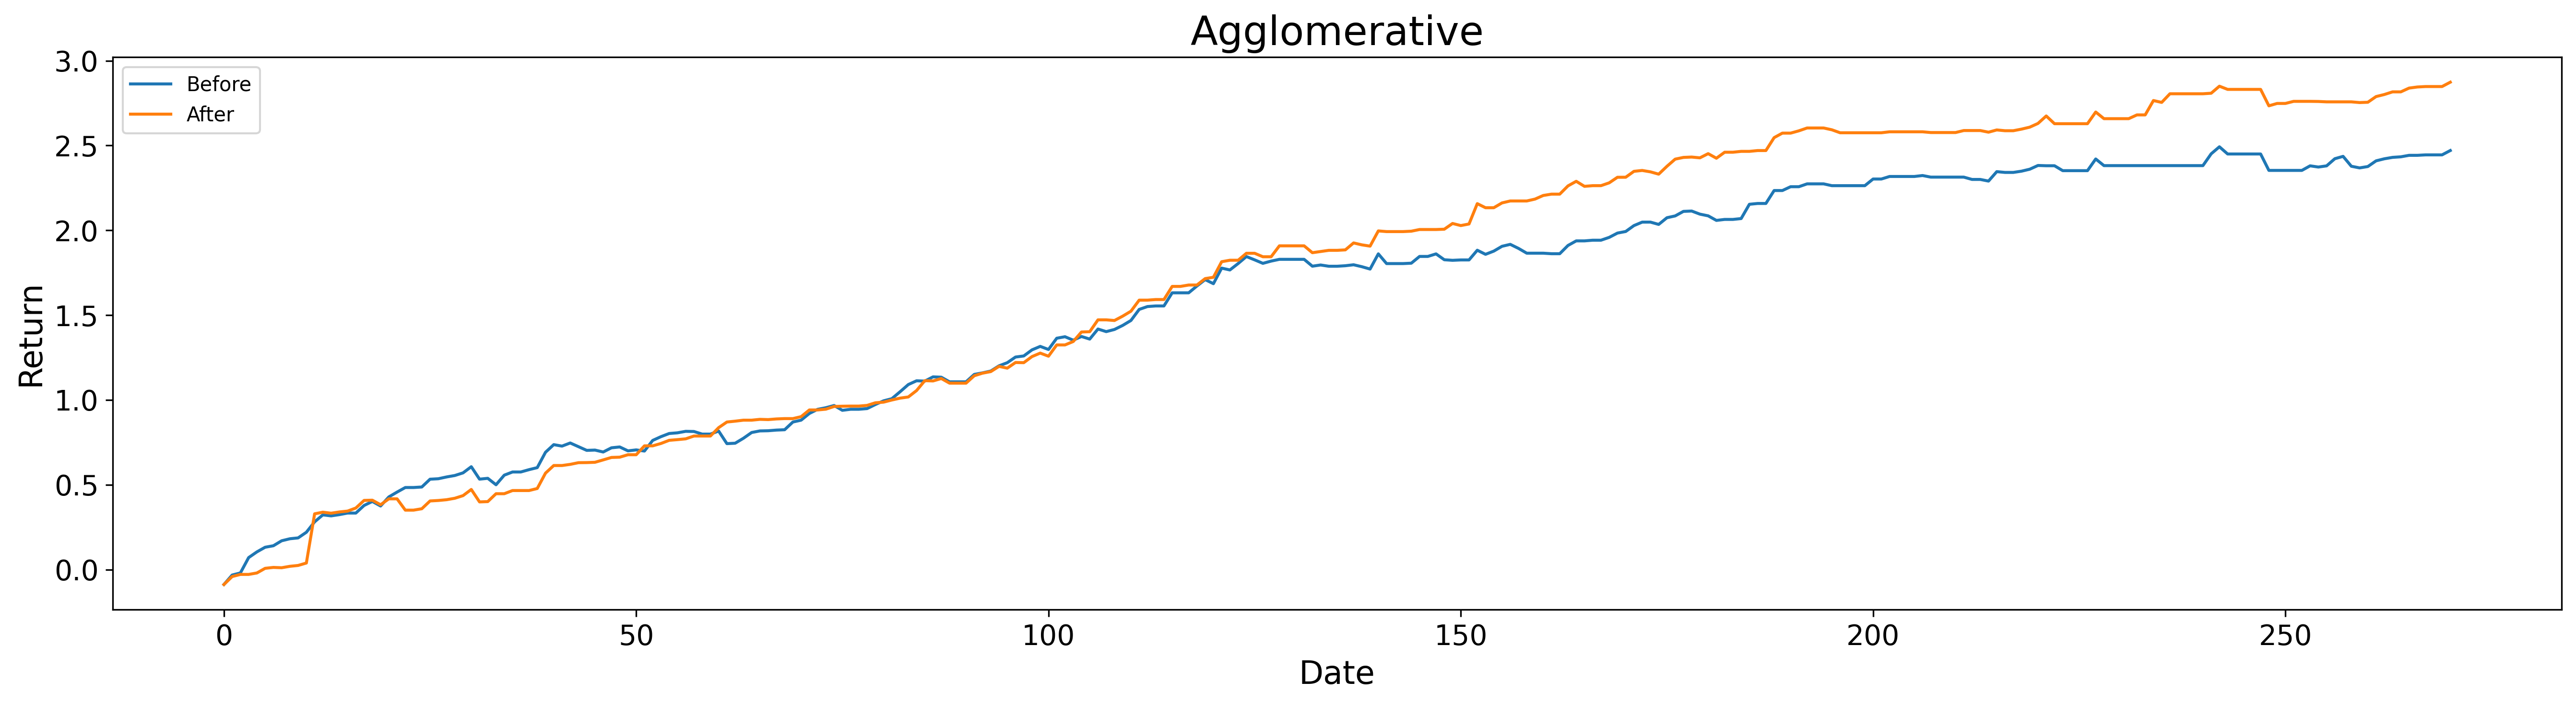

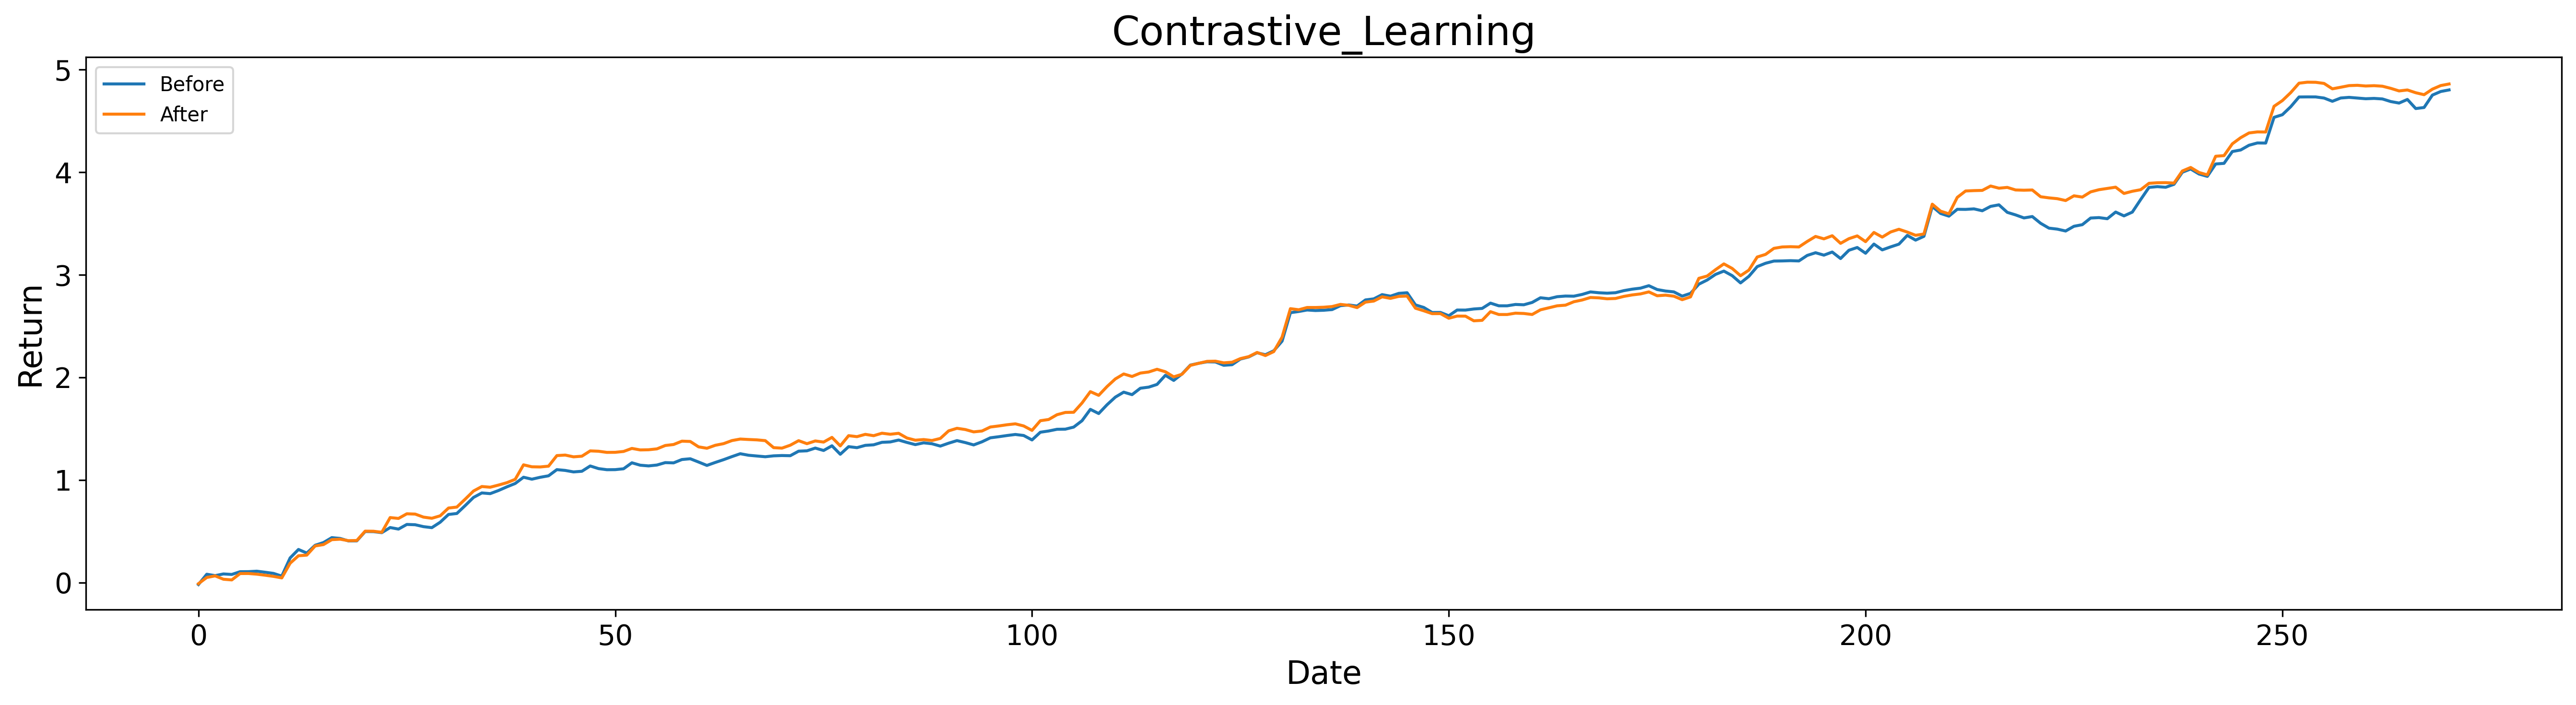

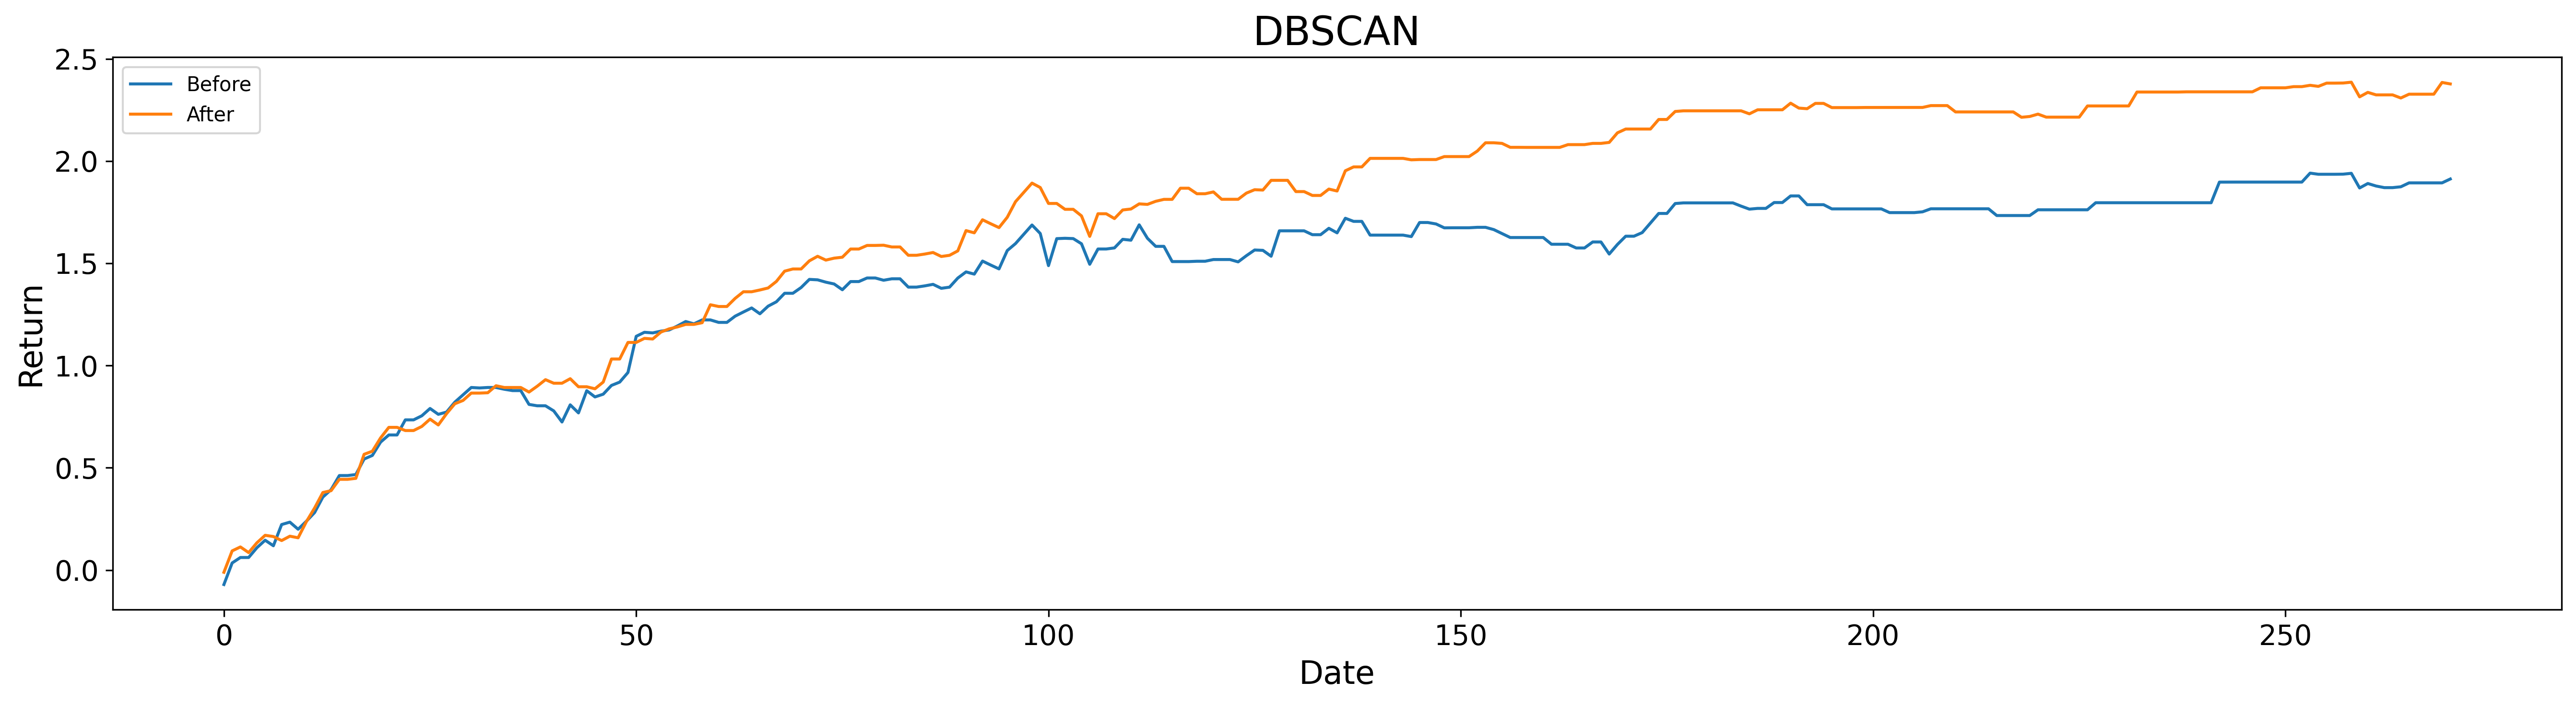

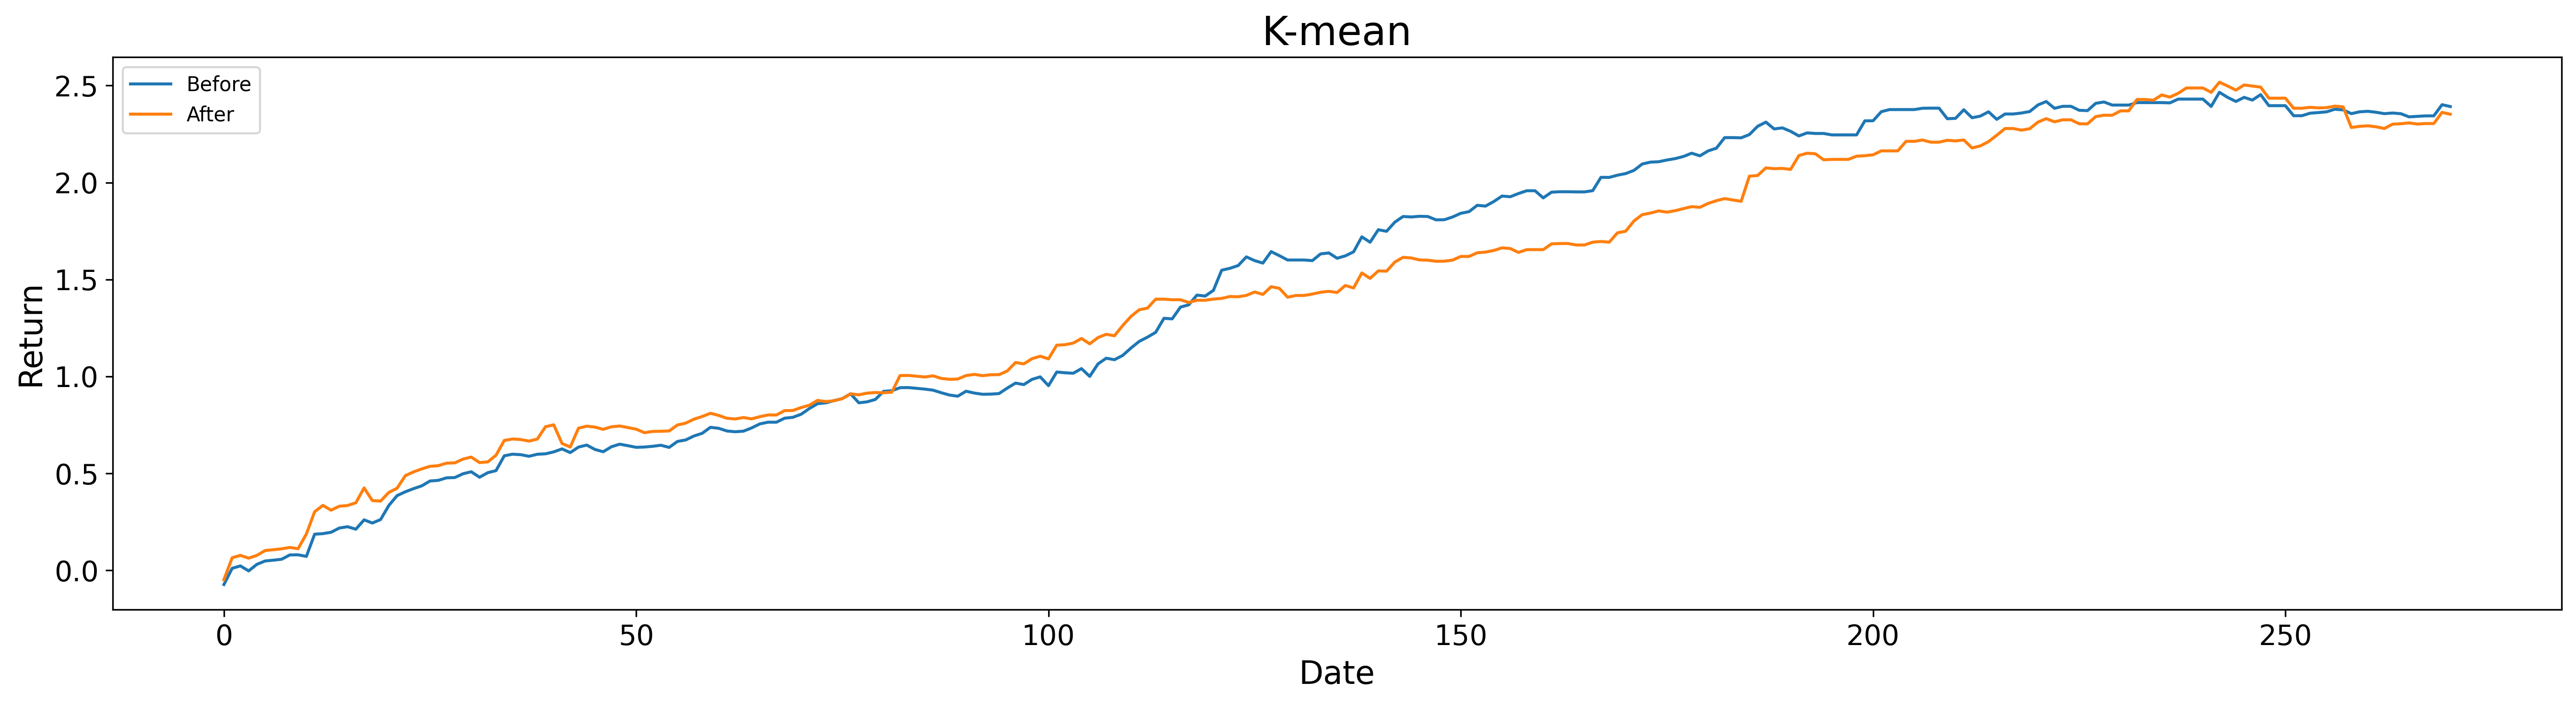

In [55]:
import matplotlib.pyplot as plt
import numpy as np

for subdir in subdirectories:
    plt.figure(figsize=(18, 5), dpi=300)
    plt.plot(pd.DataFrame(return_dict[subdir]).fillna(0).cumsum(), label='Before')
    plt.plot(pd.DataFrame(return_dict2[subdir]).fillna(0).cumsum(), label='After')

    plt.title(f'{subdir}', fontsize=20)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Return', fontsize=16)
    plt.xticks(fontsize=14)  # X축 숫자 폰트 크기
    plt.yticks(fontsize=14)  # Y축 숫자 폰트 크기
    plt.tight_layout()
    plt.legend()
    # plt.savefig(f'File/images/{subdir}.png')
    plt.show()

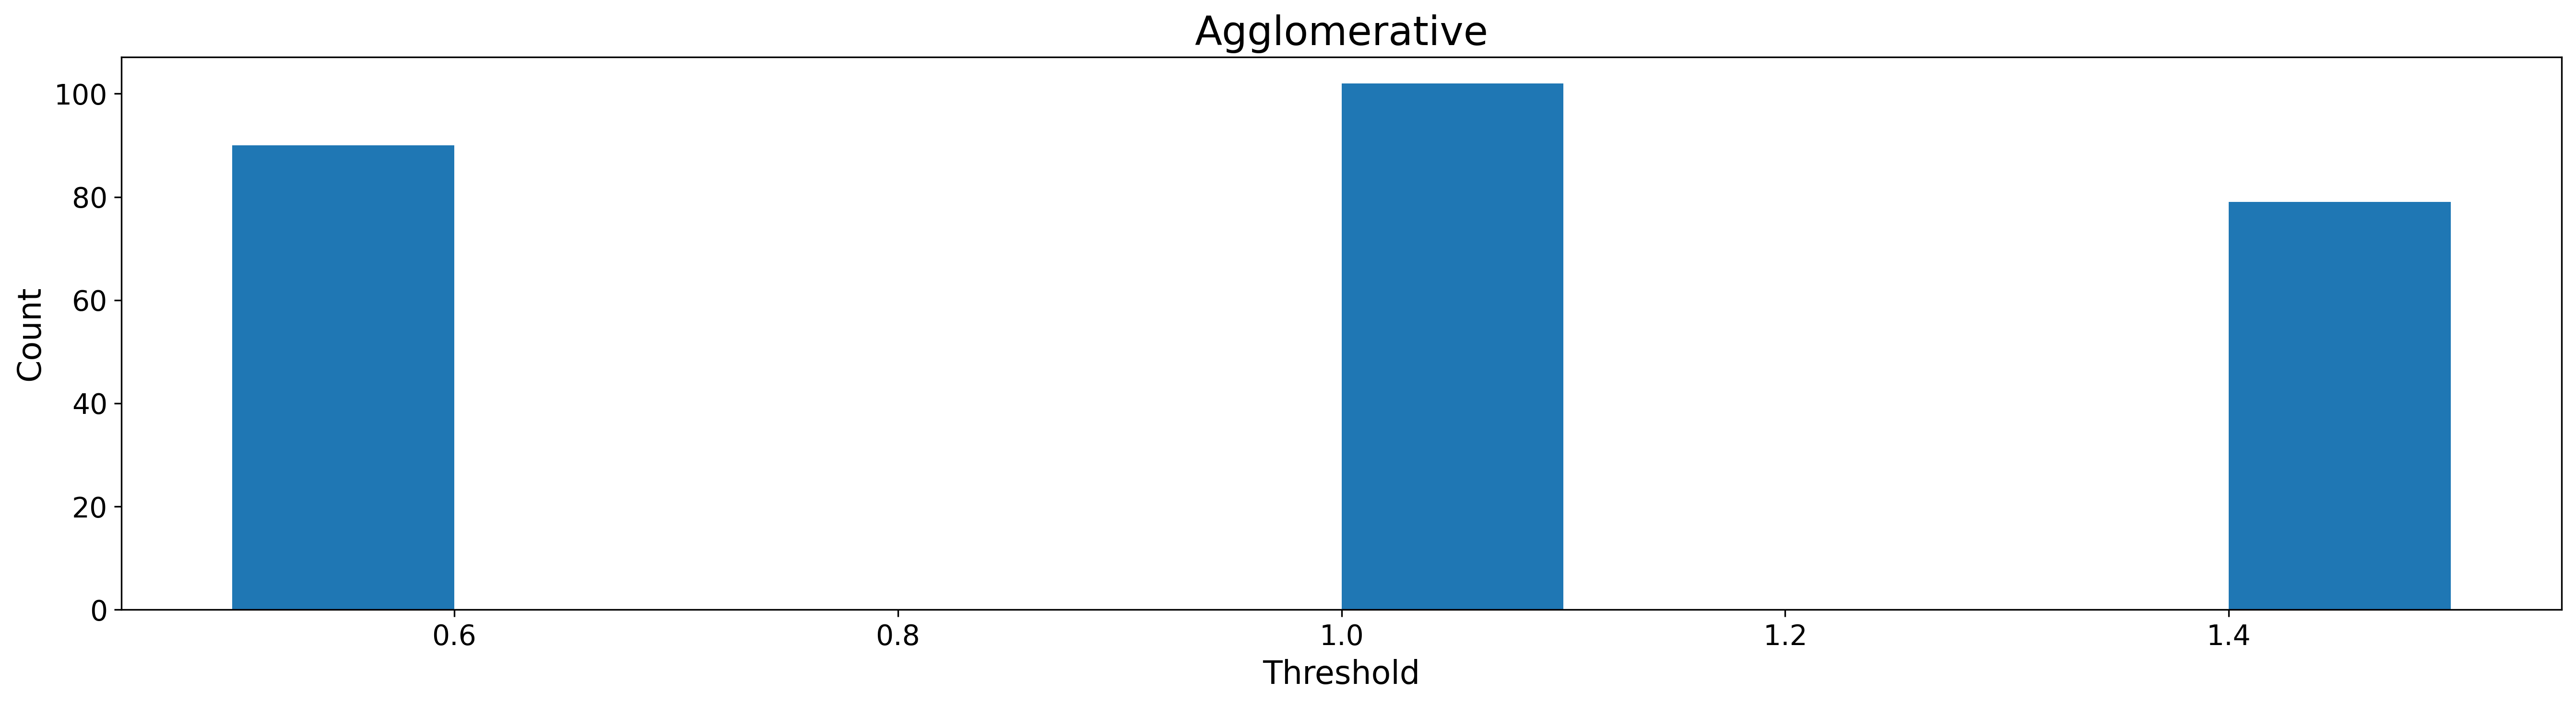

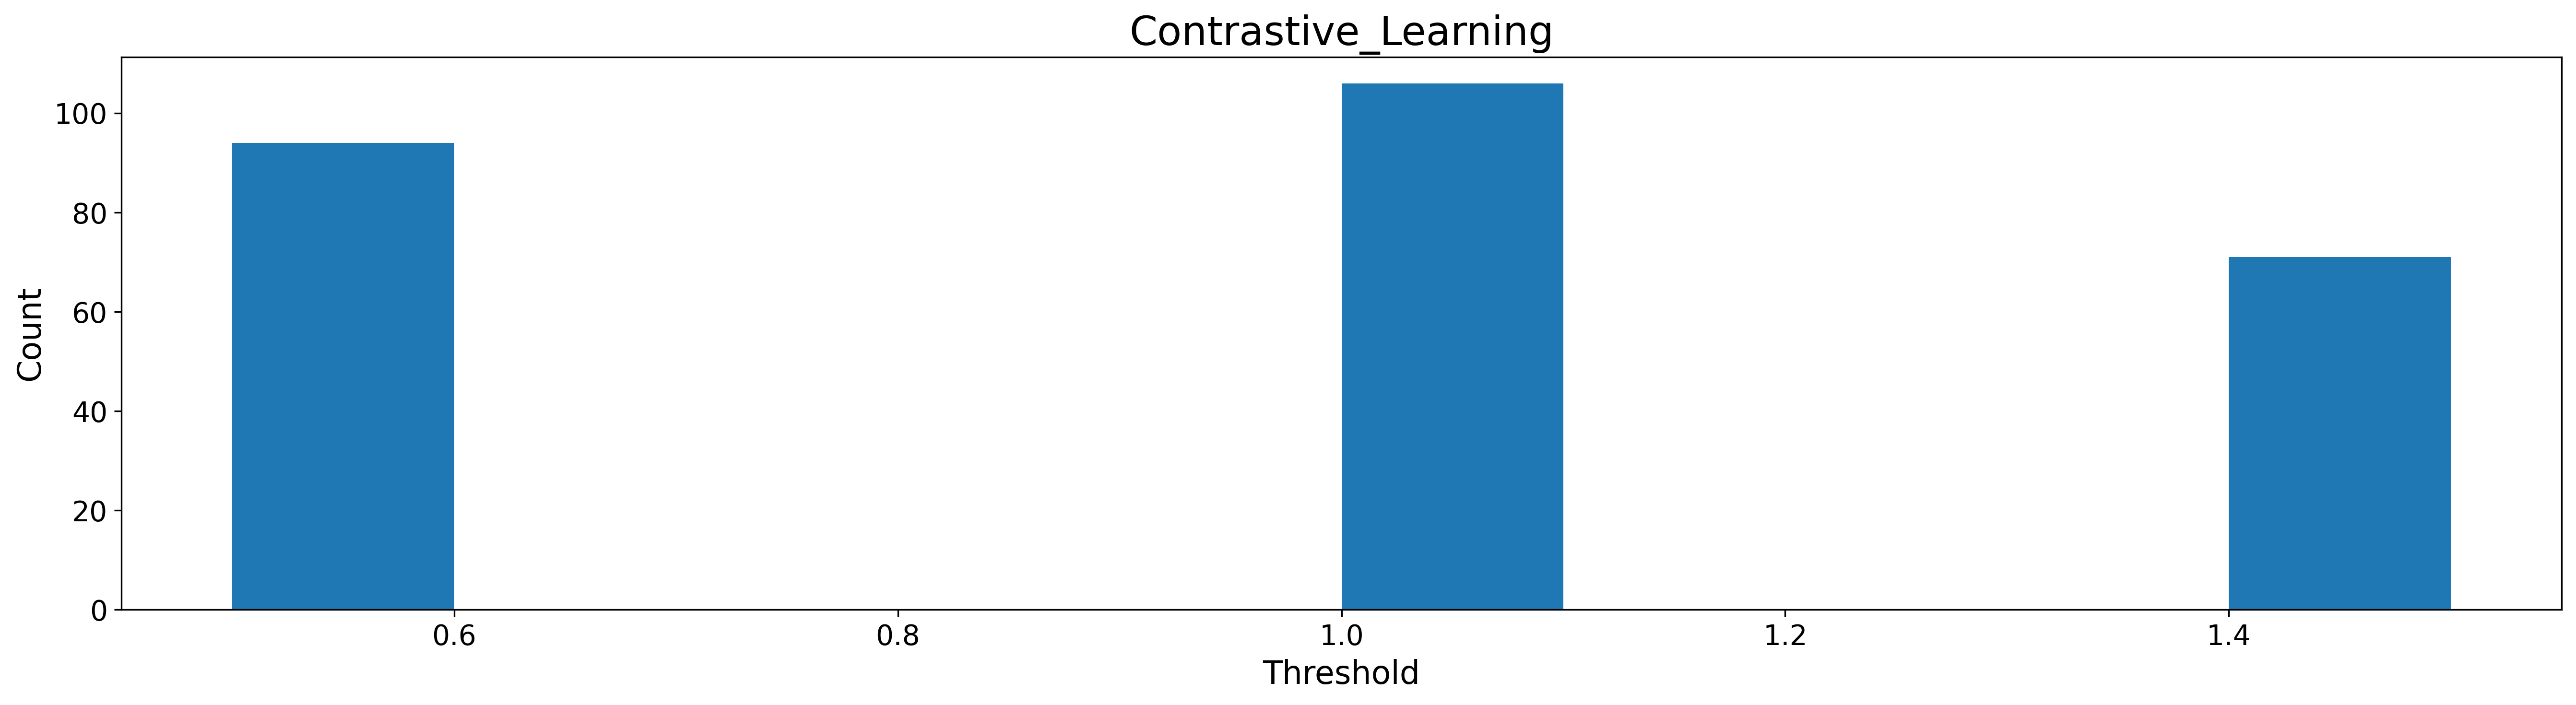

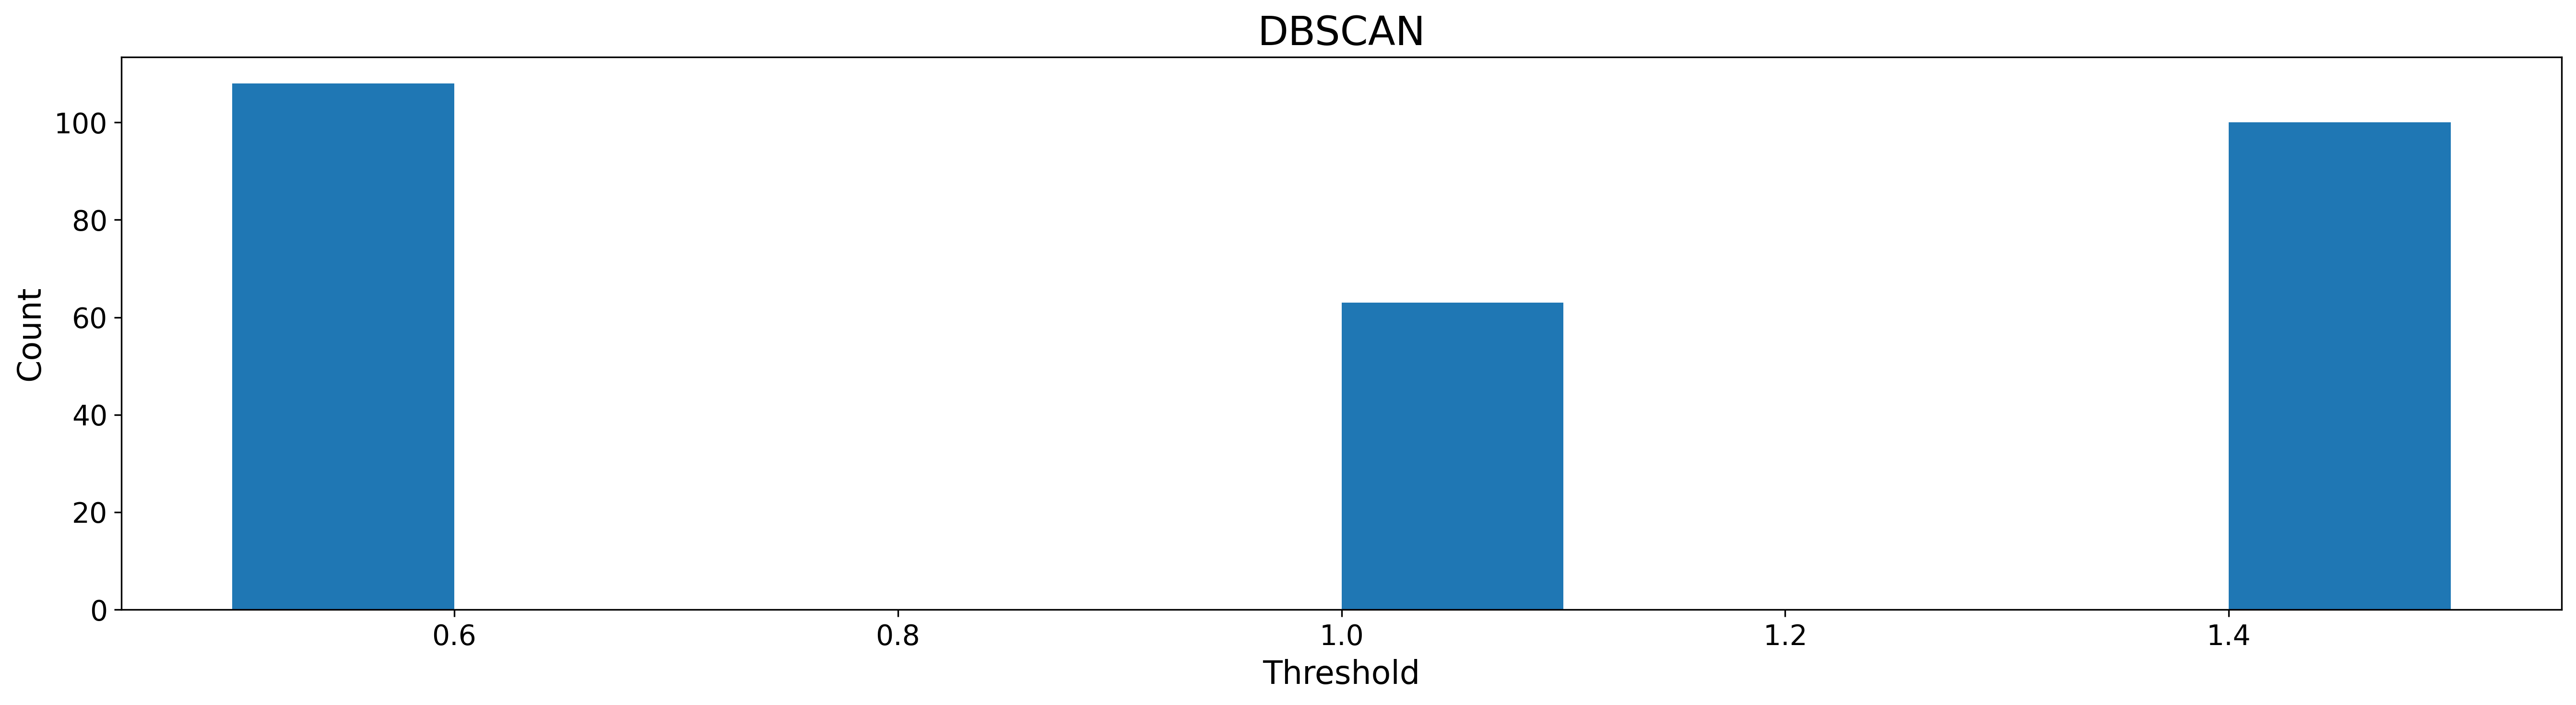

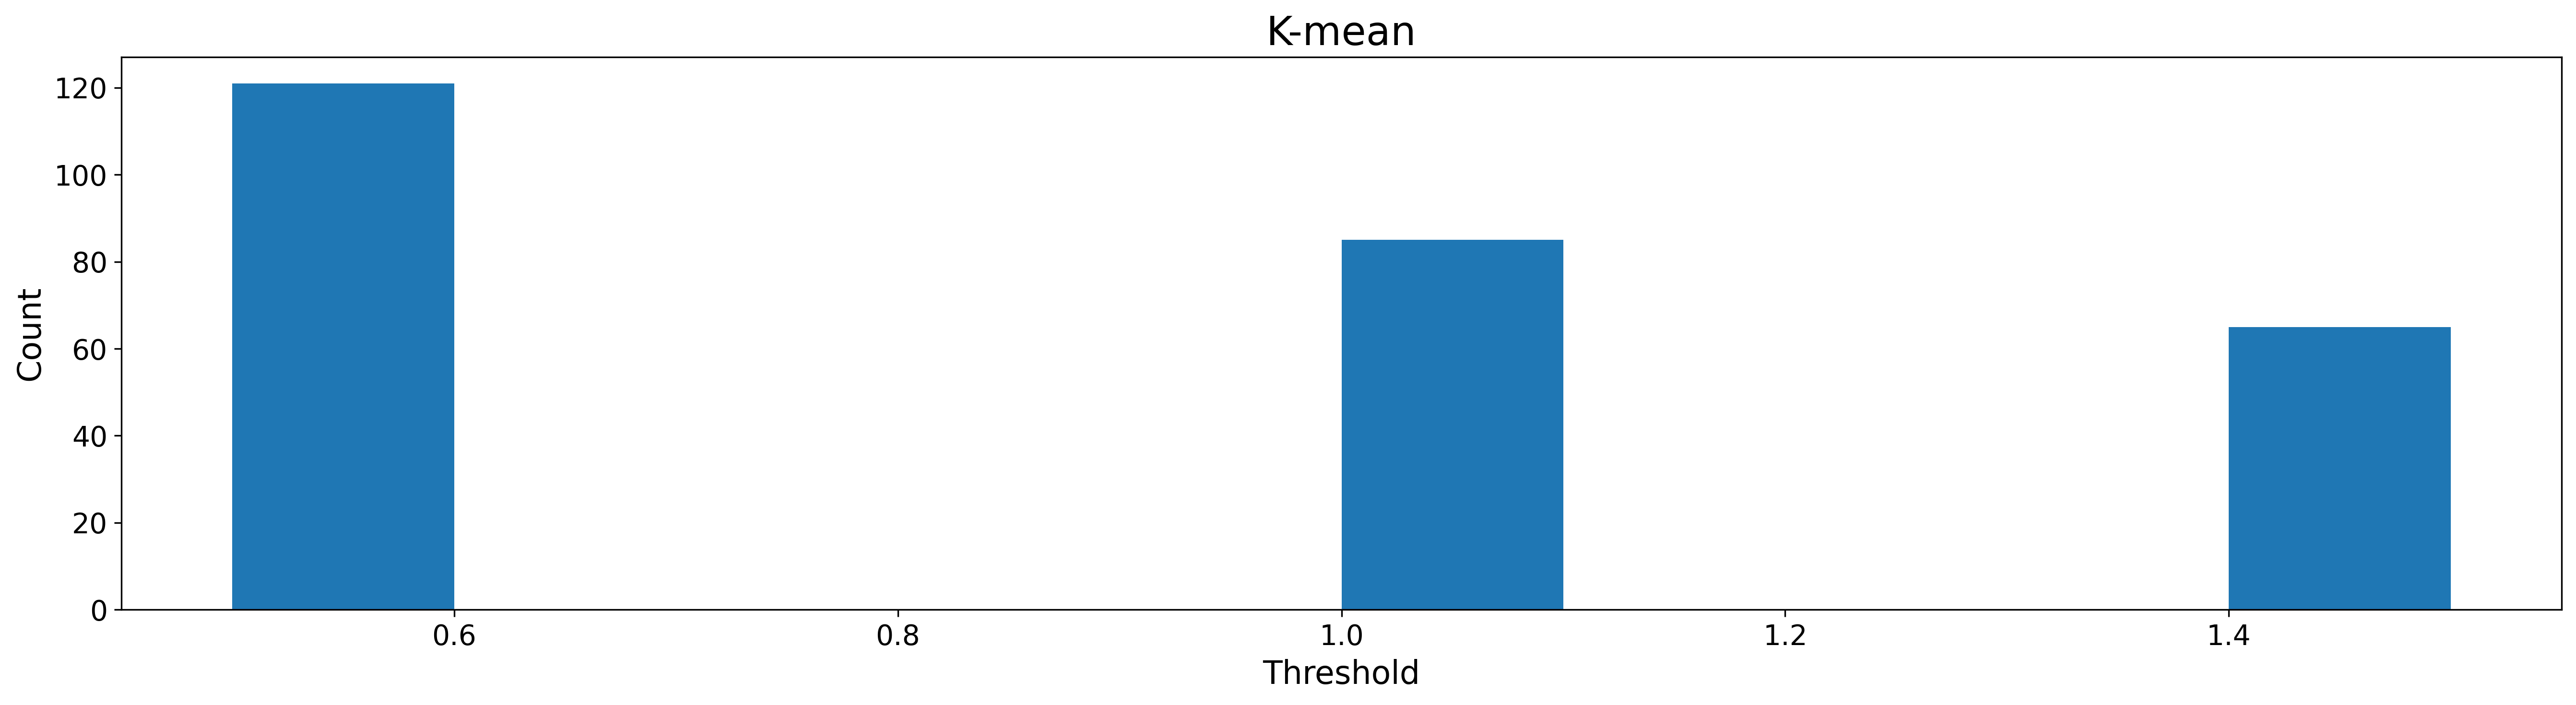

In [56]:
import matplotlib.pyplot as plt
import numpy as np

for subdir in subdirectories:
    plt.figure(figsize=(18, 5), dpi=300)
    plt.hist(np.array(action_dict2[subdir]))

    plt.title(f'{subdir}', fontsize=20)
    plt.xlabel('Threshold', fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.xticks(fontsize=14)  # X축 숫자 폰트 크기
    plt.yticks(fontsize=14)  # Y축 숫자 폰트 크기
    plt.tight_layout()
    # plt.savefig(f'File/images/{subdir}_action.png')
    plt.show()